# Convolutional Neural Networks in Pytorch

*Updated November 9: train() has a new argument for batch_size*

In [1]:
import numpy as np

import torch
print(torch.__version__)

import time

import gzip
import pickle

import matplotlib.pyplot as plt

2.1.0


Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet2D(input_shape=(1, 28, 28), 
                     conv_specs=[(20, 4, 1), (10, 3, 2)],
                     fc_specs=[20],
                     n_outputs = 10,
                     device='cpu')               
```
`conv_specs` has a sublist for each convolutional layer, specifying `(n_units, kernel_size, stride)`.

In [39]:
%%writefile convnet2d.py
import numpy as np
import torch

class ConvNet2D(torch.nn.Module):
    
    def __init__(self, input_shape, conv_specs, fc_specs, n_outputs, activation_function='tanh', device='cpu'):
        '''Example for MNIST:
        ConvNet2D((1, 28, 28), [(20, 3, 1), (10, 4, 2)], [20], 'tanh', 'cuda')
        '''

        super().__init__()
        
        self.input_shape = input_shape
        self.device = device
        print('ConvNet: Using device', self.device)
        self.activation_function = torch.nn.Tanh() if activation_function == 'tanh' else torch.nn.ReLU()
        
        # Create all convolutional layers
        n_in = input_shape[0]
        # input_hw = input_shape[1]
        self.conv_layers = torch.nn.Sequential()
        for nh, patch_size, stride in conv_specs:
            self.conv_layers.append( torch.nn.Sequential( torch.nn.Conv2d(n_in, nh, patch_size, stride),
                                                          self.activation_function) )
            n_in = nh
            # Calculate number of outputs of convolutional layers
            # conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            # input_hw = conv_layer_output_hw  # for next trip through this loop

        # Or we pass some zero input samples through the conv_layers and see how many values result
        z = self.conv_layers(torch.zeros([1] + list(input_shape)))
        z = z.reshape(1, -1)
        n_in = z.shape[1]
        
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        # n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.Sequential()
        for nh in fc_specs:
            self.fc_layers.append( torch.nn.Sequential( torch.nn.Linear(n_in, nh),
                                                        self.activation_function) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        self.fc_layers.append(output_layer)
        
        self.pc_trace = []
        self.best_pc_val = None
        self.to(self.device)

    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Zs = [X]
        for conv_layer in self.conv_layers:
            Zs.append( conv_layer(Zs[-1]) )

        # Flatten outputs from last convolutional layer.
        Zs[-1] = Zs[-1].reshape(n_samples, -1)
        for fc_layer in self.fc_layers:
            Zs.append( fc_layer(Zs[-1]) )

        return Zs
    
    def forward(self, X, keep_all_outputs=False):
        if not isinstance(X, torch.Tensor):
            X = self._X_as_torch(X)
        Zs = self._forward_all_outputs(X)
        
        if keep_all_outputs:
            self.Zs = Zs
            
        return Zs[-1]
    
    def _X_as_torch(self, X):
        if isinstance(X, torch.Tensor):
            return X
        else:
            return torch.from_numpy(X.reshape([-1] + list(self.input_shape)).astype(np.float32)).to(self.device)

    def _T_as_torch(self, T):
        if isinstance(T, torch.Tensor):
            return T
        else:
            return torch.from_numpy(T.astype(np.int64)).to(self.device)

    def percent_correct(self, Yclasses, T):
        if isinstance(T, torch.Tensor):
            return (Yclasses == T).float().mean().item() * 100
        else:
            return (Yclasses == T).mean().item() * 100
    
    def train(self, Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method='sgd', learning_rate=0.01, verbose=True):
        
        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss()
        
        if batch_size == -1:
            batch_size = Xtrain.shape[0]

        self.batch_size = batch_size  # remember this for use in forward functions


        for epoch in range(n_epochs):

            for first in range(0, Xtrain.shape[0], batch_size):
                Xtrain_batch = Xtrain[first:first + batch_size]
                Ttrain_batch = Ttrain[first:first + batch_size]

                # Set data matrices to torch.tensors if not already.
                Xtrain_batch = self._X_as_torch(Xtrain_batch)
                Ttrain_batch = self._T_as_torch(Ttrain_batch)
                # Xval = self._X_as_torch(Xval)
                # Tval = self._T_as_torch(Tval)

                Y = self(Xtrain_batch)
                loss = loss_f(Y, Ttrain_batch)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                pc_train = self.percent_correct(self.use(Xtrain), Ttrain)
                pc_val = self.percent_correct(self.use(Xval), Tval)
                self.pc_trace.append([pc_train, pc_val])

                if self.best_pc_val is None or pc_val > self.best_pc_val:
                    self.best_pc_val = pc_val
                    self.best_epoch = epoch + 1
                    # Save weights to be restored when done training
                    self.best_parameters = [p.clone() for p in self.parameters()]

            if verbose and (epoch + 1) % max(1, (n_epochs // 10)) == 0:
                print(f'{method} Epoch {epoch + 1} % Correct: Train {self.pc_trace[-1][0]:.1f}'
                      f' Val {self.pc_trace[-1][1]:.1f}')

        # Restore weights that resulted in best_pc_val
        for p, bestp in zip(self.parameters(), self.best_parameters):
            p.data = bestp.clone()

        return self

    def _softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X, return_probs=False, keep_all_outputs=False):
        
        classes = []
        probs = []
        return_numpy = False
        
        for first in range(0, X.shape[0], self.batch_size):
            X_batch = X[first:first + self.batch_size]

            if not isinstance(X_batch, torch.Tensor):
                X_batch = self._X_as_torch(X_batch)
                return_numpy = True

            with torch.no_grad():
                
                Y = self(X_batch, keep_all_outputs=keep_all_outputs)
                class_index = torch.argmax(Y, axis=1).cpu().numpy()
                classes.extend(self.classes[class_index])
                
                if return_probs:
                    probs.extend(self._softmax(Y).cpu().numpy())
                
        if return_numpy:
            classes = np.array(classes) # .cpu().numpy()
            probs = np.array(probs) # .cpu().numpy()
                    
        if return_probs:
            return classes, probs
        else:
            return classes

Overwriting convnet2d.py


In [9]:
import socket

if torch.cuda.is_available():
    print(f'{socket.gethostname()} has an available cuda GPU.')
    
if torch.backends.mps.is_available():
    print(f'{socket.gethostname()} has an available mps GPU.')
    
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# device = 'cpu'

print('Using device', device)

samuel has an available cuda GPU.
Using device cuda


In [10]:
# !nvidia-smi

In [11]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1] 
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1] 

In [12]:
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

In [13]:
from convnet2d import ConvNet2D

ConvNet: Using device cuda


/s/parsons/e/fac/anderson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


adam Epoch 1 % Correct: Train 69.5 Val 71.8
adam Epoch 2 % Correct: Train 76.1 Val 78.9
adam Epoch 3 % Correct: Train 83.5 Val 85.6
adam Epoch 4 % Correct: Train 86.3 Val 88.4
adam Epoch 5 % Correct: Train 87.8 Val 89.5
% Correct Test 89.5


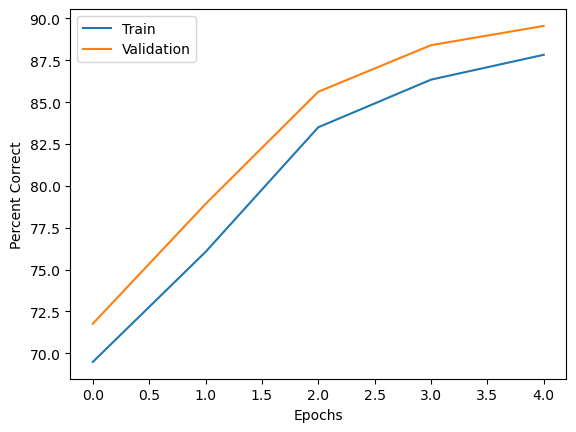

In [14]:
input_shape = (1, 28, 28)
n_outputs = 10

conv_specs = [(40, 4, 1), (10, 3, 2)]
fc_specs = [20]

batch_size = -1  # means all training samples used in a single batch
batch_size = 5000
n_epochs = 5

nnet = ConvNet2D(input_shape, conv_specs, fc_specs, n_outputs, 
                 activation_function='tanh', device=device)
nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size, method='adam', 
           learning_rate=0.001, verbose=True)

Y = nnet(Xval)
print(f'% Correct Test {nnet.percent_correct(nnet.use(Xval), Tval):.1f}')

plt.plot(nnet.pc_trace)
plt.xlabel('Epochs')
plt.ylabel('Percent Correct')
plt.legend(('Train', 'Validation'));

In [15]:
Xtest[0].shape

(784,)

In [16]:
X = Xtest[0].reshape(1, 28, 28)
T = Ttest[0]
Zs = nnet.use(X, keep_all_outputs=True)
len(Zs)

1

In [17]:
len(nnet.Zs)

5

In [18]:
Ws = list(nnet.parameters())
len(Ws)

8

In [19]:
[W.shape for W in Ws]

[torch.Size([40, 1, 4, 4]),
 torch.Size([40]),
 torch.Size([10, 40, 3, 3]),
 torch.Size([10]),
 torch.Size([20, 1440]),
 torch.Size([20]),
 torch.Size([10, 20]),
 torch.Size([10])]

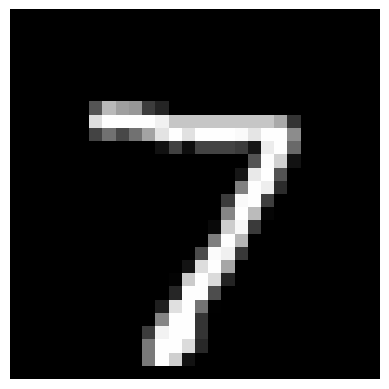

In [20]:
plt.imshow(X.squeeze(), cmap='gray')
plt.axis('off');

In [21]:
W_layer1 = list(nnet.parameters())[0]
W_layer1.shape

torch.Size([40, 1, 4, 4])

In [22]:
len(nnet.Zs)

5

In [23]:
[Z.shape for Z in nnet.Zs]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 40, 25, 25]),
 torch.Size([1, 1440]),
 torch.Size([1, 20]),
 torch.Size([1, 10])]

In [24]:
n_units_layer_1 = 40

In [25]:
Z_layer1 = nnet.Zs[1]
Z_layer1.shape

torch.Size([1, 40, 25, 25])

In [26]:
Z_layer1 = Z_layer1.reshape(40, 25, 25)
Z_layer1.shape

torch.Size([40, 25, 25])

(-0.5, 27.5, 27.5, -0.5)

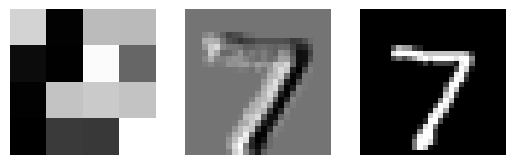

In [27]:
plt.subplot(1, 3, 1)
plt.imshow(W_layer1[0, 0, :, :].detach().cpu(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(Z_layer1[0, :, :].detach().cpu(), cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(X.squeeze(), cmap='gray')
plt.axis('off')

In [28]:
np.random.randint(10)

3

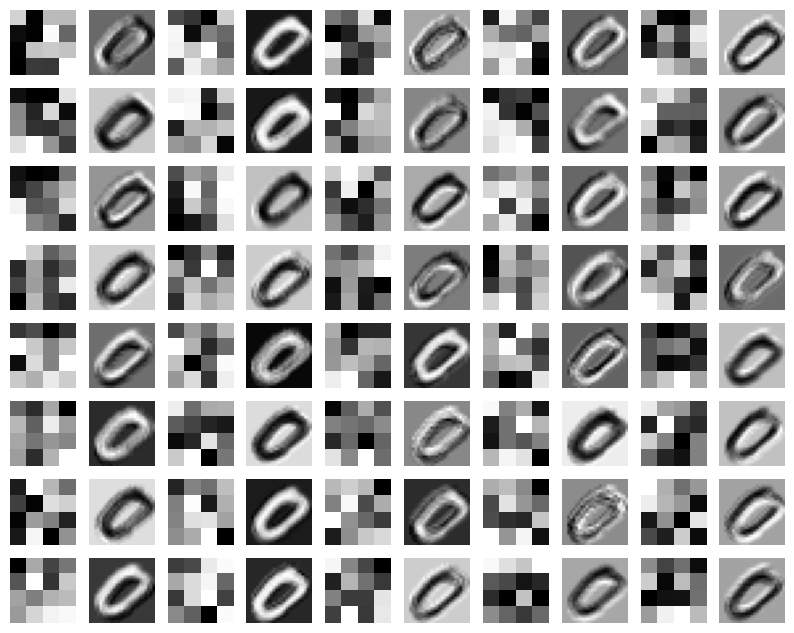

In [30]:
W_layer1 = list(nnet.parameters())[0]

random_digit = np.random.randint(Xtest.shape[0])
X = Xtest[random_digit].reshape(28, 28)    
nnet.use(X, keep_all_outputs=True)
Z_layer1 = nnet.Zs[1].reshape(40, 25, 25)

plt.figure(figsize=(10,10))
ploti = 0
for unit in range(40):
    ploti += 1
    plt.subplot(10, 10, ploti)
    plt.imshow(W_layer1[unit, 0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 10, ploti)
    plt.imshow(Z_layer1[unit, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')

In [31]:
nnet

ConvNet2D(
  (activation_function): Tanh()
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 40, kernel_size=(4, 4), stride=(1, 1))
      (1): Tanh()
    )
    (1): Sequential(
      (0): Conv2d(40, 10, kernel_size=(3, 3), stride=(2, 2))
      (1): Tanh()
    )
  )
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1440, out_features=20, bias=True)
      (1): Tanh()
    )
    (1): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [32]:
[Z.shape for Z in nnet.Zs]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 40, 25, 25]),
 torch.Size([1, 1440]),
 torch.Size([1, 20]),
 torch.Size([1, 10])]

In [33]:
n_units_layer_2 = 10

In [34]:
1440 / n_units_layer_2

144.0

In [35]:
np.sqrt(144)

12.0

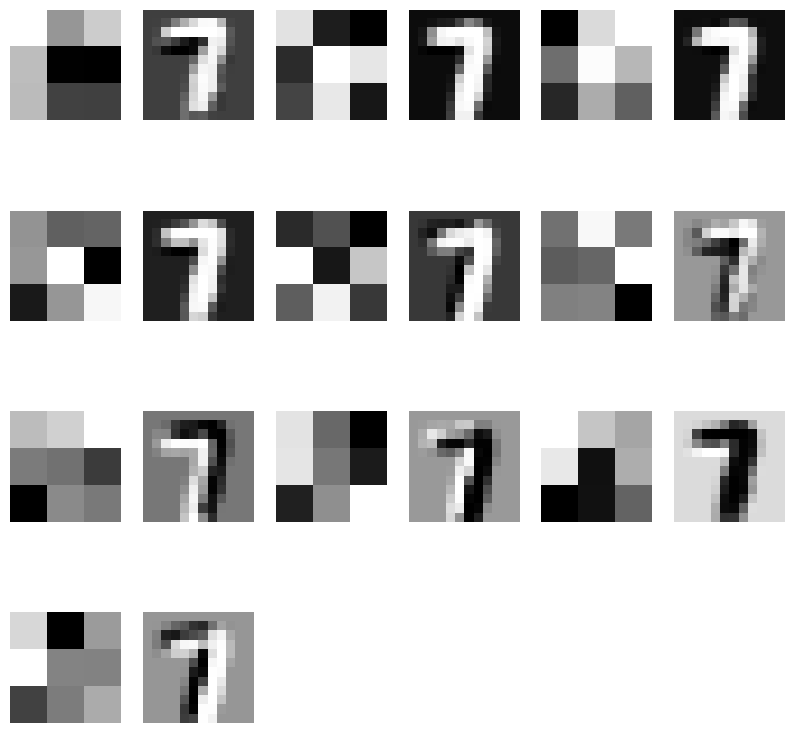

In [36]:
W_layer2 = list(nnet.parameters())[2]  # skip bias weight in layer 1

random_digit = np.random.randint(Xtest.shape[0])
X = Xtest[random_digit].reshape(28, 28)    
nnet.use(X, keep_all_outputs=True)
Z_layer2 = nnet.Zs[2].reshape(n_units_layer_2, 12, 12)
n_units = Z_layer2.shape[0]

plt.figure(figsize=(10,10))
ploti = 0
for unit in range(10):
    ploti += 1
    plt.subplot(4, 6, ploti)
    plt.imshow(W_layer2[unit, 0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(4, 6, ploti)
    plt.imshow(Z_layer2[unit, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')

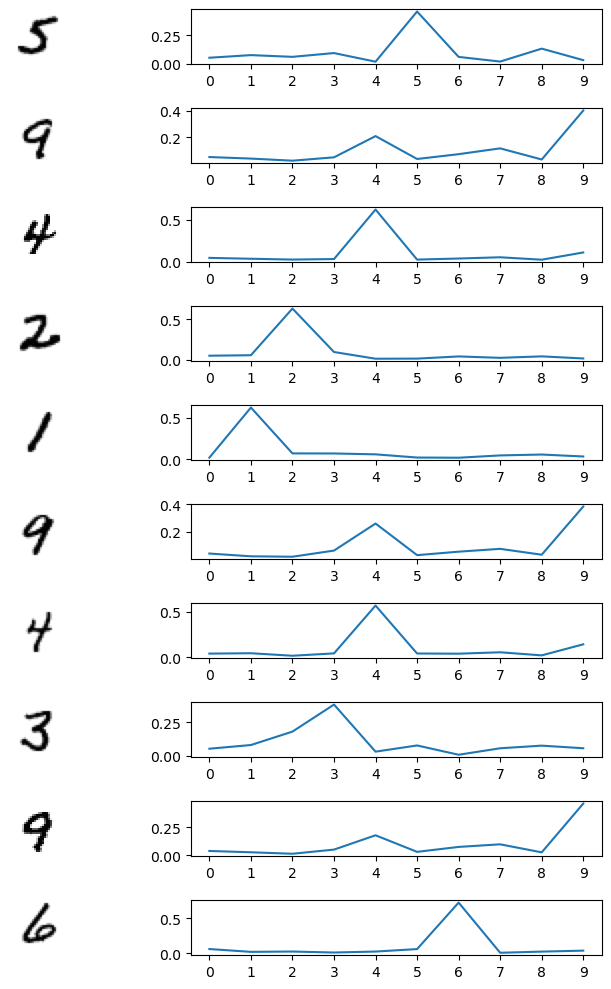

In [38]:
first = np.random.randint(10000 - 20)

Xs = Xtest[first:first + 20].reshape(-1, 1, 28, 28)
classes, probs = nnet.use(Xs, return_probs=True)

plt.figure(figsize=(8, 10))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(-Xs[i, 0, :, :], cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    Yprobs = probs[i, :]
    plt.plot(Yprobs)
    plt.xticks(range(10))
plt.tight_layout()